## 1. 패키지 로딩하기

In [1]:
from IPython import display
from matplotlib.pylab import rcParams

import os
import PIL
import glob
import time
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## 2. 데이터 불러오기

In [2]:
cifar10                   = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()       # y_train, y_test 데이터는 필요하지 않음.

#### 2_1. 데이터 살펴보기

In [3]:
print("train max pixel :", train_x.max())
print("train min pixel :", train_x.min())
print("train shape :",     train_x.shape)

train max pixel : 255
train min pixel : 0
train shape : (50000, 32, 32, 3)


In [4]:
print("test max pixel :", test_x.max())
print("test min pixel :", test_x.min())
print("test shape :",     test_x.shape)

test max pixel : 255
test min pixel : 0
test shape : (10000, 32, 32, 3)


* 이미지 데이터이므로 0 ~ 255 사이의 값을 가지고, 둘 다 (32, 32, 3)의 shape을 가지고 있다.
* train 데이터는 50,000장, test 데이터는 10,000장 있다.

#### 2_2. 데이터 시각화하여 살펴보기

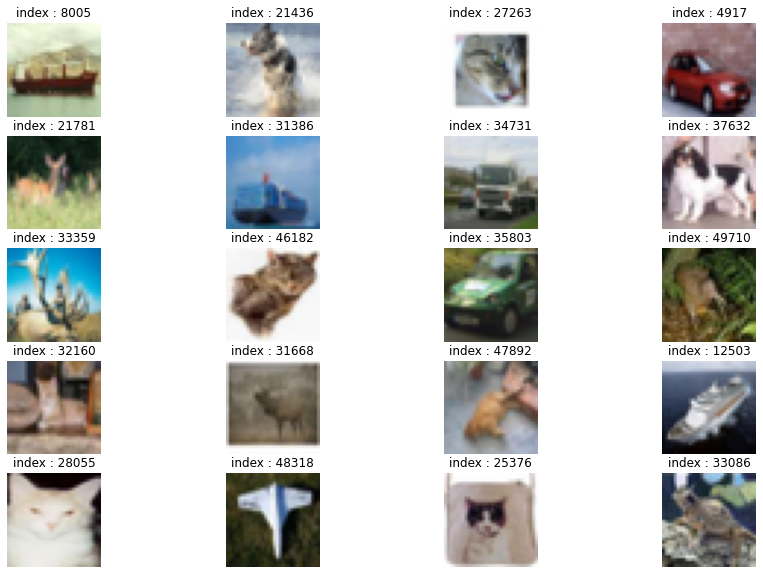

In [5]:
plt.figure(figsize = (15, 10))                 # 그림 사이즈 설정하기

for i in range(20):                            # 20개를 임의로 뽑아서 시각화하기
    plt.subplot(5, 4, i + 1)                   # 5행 4열로 20개 그림을 보여준다. (row, col, index)
    random_index = np.random.randint(1, 50000) # 랜덤하게 뽑힐 숫자 정하기
    plt.imshow(train_x[random_index])          # random_index에 해당하는 그림을 그린다
    plt.title(f"index : {random_index}")       # 각 그림마다 제목 달아주기
    plt.axis("off")                            # 불필요한 축 제거
    
plt.show()                                     # 시각화 보여주기

#### 2_3. 학습에 사용할 train_x 데이터를 [-1, 1] 사이로 정규화 시키기

In [6]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화 시키려고 중간값을 0으로 맞추고(그를 위해 127.5를 뺸다) 127.5로 나눈다.

print("train max pixel :", train_x.max())
print("trian min pixel :", train_x.min())
print("train shape :", train_x.shape)

train max pixel : 1.0
trian min pixel : -1.0
train shape : (50000, 32, 32, 3)


#### 2_4. from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성하기

In [7]:
buffer_size = 50000 # 전체 데이터를 섞기 위해 50000으로 지정한다.
batch_size  = 256   # 모델이 한번에 학습할 데이터의 양을 지정한다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(buffer_size).batch(batch_size) # 텐서 자료형에서 데이터셋을 만듬

## 3. 생성자 모델 구현하기

#### 3_1. 생성자 모델을 만드는 함수 만들기

* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 만들어 본다.
* 모델의 구현은 Keras Sequential API를 활용했다. 밑의 코드는 Tensorflow 2.0 Tutorial의 DCGAN 구현을 기반으로 상세한 설명을 추가했다.

In [8]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential() # Sequential() 구조로 시작하여 구조를 쌓을 것 이다.
    
    # First : Dense layer
    model.add(tf.keras.layers.Dense(8 * 8 * 256, use_bias = False, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size = (5, 5), strides = (1, 1), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fifth : Conv2Dtrainspose layer
    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False, activation = "tanh"))
    
    return model

* 여기에서 가장 중요한 레이어는 바로 Conv2DTranspose 레이어이다.
* Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다.
* 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나갑니다.
* 여기서 최종 사이즈인 (32, 32, 3)은 우리가 준비했던 데이터셋과 shape이 동일하다.

#### 3_2. 모델을 생성하고 구조 보기

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

#### 3_3. 모델이 잘 작동되는지 테스트해보기

* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 본다.

In [10]:
noise           = tf.random.normal([1, 100])         # [1, 100]의 랜덤 노이즈 1개를 생성한다.
generated_image = generator(noise, training = False) # noise를 모델에 넣고 이미지를 생성해본다.
                                                     # 아직 훈련되지 않은 모델이기에 만든 이미지가 큰 의미가 없을 것이다.
                                                     # 모델이 잘 작동되는지 확인하는 차원이니 훈련이 되면 안되므로 training = False를 했다.

* 생성한 결과물을 시각화도 해보고 shape도 보자.

In [11]:
# shape 출력하기
print("generated image :", generated_image.shape)

generated image : (1, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


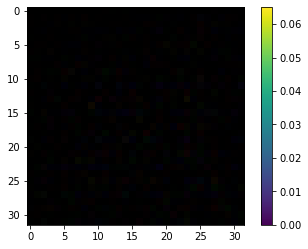

In [12]:
# 결과물 시각화 해보기
plt.imshow(generated_image[0])          # plt는 2차원만 보여줄 수 있기에 (32, 32) 부분만 출력한다.
plt.colorbar()                          # 이미지 옆에 컬러별 값을 표시해준다. 정규화를 시켰으므로 -1 ~ 1 사이의 값만 존재할 것이다.
plt.show()                              # 시각화 보여주기

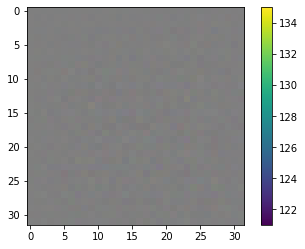

In [13]:
# 결과물 시각화 해보기
plt.imshow(np.int64((generated_image[0] * 127.5) + 127.5))          # plt는 2차원만 보여줄 수 있기에 (32, 32) 부분만 출력한다.
plt.colorbar()                          # 이미지 옆에 컬러별 값을 표시해준다. 정규화를 시켰으므로 -1 ~ 1 사이의 값만 존재할 것이다.
plt.show()                              # 시각화 보여주기

## 4. 판별자 모델 구현하기

#### 4_1. 판별자 모델을 만드는 함수 만들기

* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해본다.

In [14]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(tf.keras.layers.Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = "same", input_shape = [32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(tf.keras.layers.Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = "same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Third : Flatten layer
    model.add(tf.keras.layers.Flatten())
    
    # Fourth : Dense layer
    model.add(tf.keras.layers.Dense(1))
    
    return model

* 판별자는 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 한다.
* 그러므로 입력은 (32, 32, 3) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것이다.
* 판별자는 Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
* 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 된다.
* 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128 = 8,192, 즉 (1, 8192) 형상의 벡터로 변환한다. 
* 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 한다. 
* 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 된다.

#### 4_2. 모델을 생성하고 구조 보기

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

#### 4_3. 모델이 잘 작동되는지 테스트해보기

* 위처럼 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [16]:
decision = discriminator(generated_image, training = False)
decision
# 매우 0에 가까운 값이 나온다.

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00015231]], dtype=float32)>

## 5. 손실함수와 최적화 함수 구현하기

#### 5_1. 생성자와 판별자의 손실함수(loss)를 구현하기

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

* 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었다.
* 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠.

* BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0 ~ 1 사이에 분포하는 확률값이라고 가정한다. 
* 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.

In [18]:
# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

* generator_loss는 fake_output가 1에 가까워지기를 바라므로, 위와 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 된다.
* 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [19]:
# discriminator_loss
def discriminator_loss(read_output, fake_output):
    real_loss  = cross_entropy(tf.ones_like(read_output),  read_output)
    fake_loss  = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산한다.
* real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 된다.
* 최종 discriminator_loss 값은 이 둘을 더한 값이다.

#### 5_2. 판별자의 출력값을 가지고 실제 / 생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현하기.

In [20]:
# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# 간단한 예시를 통해 위에 코드의 해석을 돕겠다.
# ex) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9])를 가지고 보면,

# (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
# ex) tf.Tensor([False, False, True, True])

# (2) tf.cast((1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
# ex) tf.Tensor([0.0, 0.0, 1.0, 1.0])

# (3) tf.reduce_mean((2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
# >> 0.5

* 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 
* 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.

* 만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면?
* 이 경우는 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다.
* 그래서 real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. 
* fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이라고 해석하면 된다.

#### 5_3. 생성자와 판별자를 최적화하는 optimizer를 구현하기

* 최적화 함수에는 Adam를 사용할 것이다.
* 학습 품질을 올려보고 싶다면 중요한 하이퍼 파라미터 중 하나인 learning rate를 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천하고 있다.
* 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점이다.

In [21]:
lr = 1e-4                                              # Learning rate : 하이퍼 파라미터, 여러가지 값으로 바꿔가면서 학습을 시켜보자.

generator_optimizer     = tf.keras.optimizers.Adam(lr) # 생성자 최적화 함수
discriminator_optimizer = tf.keras.optimizers.Adam(lr) # 판별자 최적화 함수

#### 5_4. 매번 학습이 어떻게 진행되어가고 있는지 확인하기 위해 생성자가 생성한 샘플을 확인하기

* 샘플은 한 번에 16장을 생성하도록 설정할 것이다.
* 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으니, 고정된 seed 노이즈를 만들 것이다.
* 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들겠다.

In [22]:
noise_dim                = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 6. 훈련과정 상세 기능 구현하기

#### 6_1. 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수 구현하기

In [23]:
@tf.function # @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환된다.
             # 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것이다.
def train_step(images):                               # 입력데이터 : Real Image 역할을 할 images 한 세트를 입력으로 받음.
    noise = tf.random.normal([batch_size, noise_dim]) # 생성자 입력 노이즈 : generator가 Fake Image를 생성하기 위한 noise를 images 한 세트와 같은 크기인 batch_size 만큼 생성함.
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # tf.GradientTape() 오픈 : 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기.
        generated_images = generator(noise, training = True)            # generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성.
        
        # discriminator 판별
        real_output = discriminator(images,           training = True) # discriminator가 Real Image인 images를 입력받은 후 real_output 출력.
        fake_output = discriminator(generated_images, training = True) # discriminator가 Fake Image인 generated_images를 입력받은 후 fake_output 출력.
        
        # loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산.
        gen_loss  = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy 계산 : discriminator의 각각 accuracy 계산.
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴.
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

#### 6_2. 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현하기

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training = False)
    
    fig = plt.figure(figsize = (4, 4))                         # 그림 사이즈 설정하기
    for i in range(predictions.shape[0]):                      # predictions.shape[0] 시각화하기 : 여기서는 16개를 시각화 한다.
        plt.subplot(4, 4, i + 1)                               # 4행 4열로 그림을 보여준다. (row, col, index)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5)) # predictions[i]에 해당하는 그림을 그린다.
        plt.axis("off")                                        # 불필요한 축 제거
        
    # ""안의 이름으로 그림을 저장한다.
    plt.savefig("{}/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png".format(os.getenv("HOME"), epoch, it))
    
    plt.show()                              # 시각화 보여주기

#### 6_3. 훈련 epoch마다 생성자 / 판별자의 loss 및 판별자의 실제 / 생성(real / fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현하기

In [25]:
rcParams["figure.figsize"] = 15, 6 # matlab 차트의 기본 크기를 15, 6으로 지정한다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(2, 1, 1)                                               # 위치 지정
    plt.plot(history["gen_loss"])                                      # gen_loss 선 그래프 그리기
    plt.plot(history["disc_loss"])                                     # disc_loss 선 그래프 그리기
    plt.title("Model Loss")                                            # 그림 제목 지정
    plt.ylabel("loss")                                                 # x축 이름 지정
    plt.xlabel("batch iters")                                          # y축 이름 지정
    plt.legend(["gen_loss, disc_loss"], loc = "upper left")            # 범주 만들기
    
    # summarize history for accuracy
    plt.subplot(2, 1, 2)                                               # 위치 지정
    plt.plot(history["fake_accuracy"])                                 # fake_accuracy 선 그래프 그리기
    plt.plot(history["real_accuracy"])                                 # real_accuracy 선 그래프 그리기
    plt.title("Discriminator Accuracy")                                # 그림 제목 지정
    plt.ylabel("accuracy")                                             # x축 이름 지정
    plt.xlabel("batch iters")                                          # y축 이름 지정
    plt.legend(["fage_accuracy", "real_accuracy"], loc = "upper left") # 범주 만들기
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig("{}/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/training_history/train_history_{:04d}.png".format(os.getenv("HOME"), epoch))
    plt.show()

#### 6_4. training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정하기

* tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다.
* 모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적이다.
* checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장한다.
* 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장하는 것이다. 
* 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.

In [26]:
checkpoint_dir    = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/training_checkpoints"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint        = tf.train.Checkpoint(generator_optimizer     = generator_optimizer,
                                        discriminator_optimizer = discriminator_optimizer,
                                        generator               = generator,
                                        discriminator           = discriminator)

## 7. 학습 과정 진행하기

* 위 6에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 보기.
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 보기.
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출하기.

#### 7_1. 지금까지 만든 함수를 한 곳에 합치기

In [27]:
def train(dataset, epochs, save_every): # epochs : 전체 학습 에포크를 결정, save_every : 모델을 저장하는 간격을 담당
    start   = time.time()
    history = {"gen_loss" : [], "disc_loss" : [], "real_accuracy" : [], "fake_accuracy" : []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait = True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print("Epoch {} | iter {}".format(epoch + 1, it + 1))
                print("Time for epoch {} : {} sec".format(epoch + 1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, it, seed)
        print("Time for training : {} sec".format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

#### 7_2. 모델의 하이퍼파라미터 지정하기

In [28]:
save_every = 5
epochs     = 500

#### 7_3. 모델 학습 시작하기

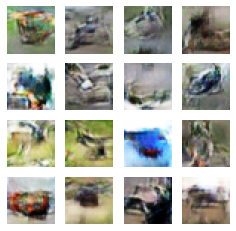

Time for training : 5839 sec


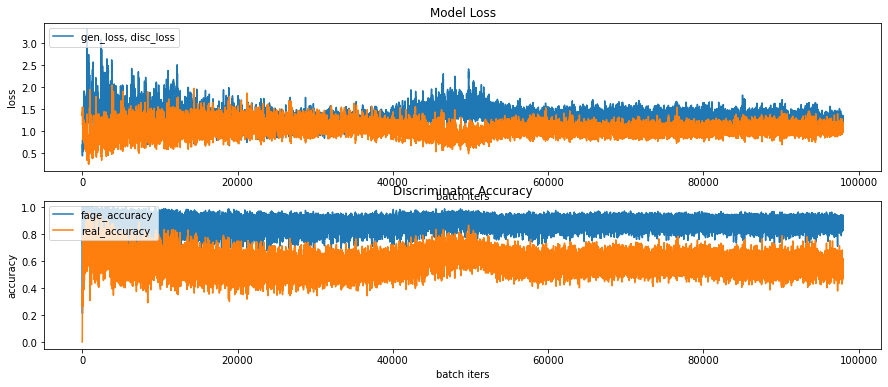

CPU times: user 1h 37min 35s, sys: 3min 26s, total: 1h 41min 1s
Wall time: 1h 37min 22s


In [29]:
%%time
train(dataset = train_dataset, epochs = epochs, save_every = save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성된다.
# 진행 과정을 수시로 확인해 보는 것을 권장한다.

#### 7_4. checkpoint 모듈을 활용하여 모델을 로드하는 예시

In [30]:
# # checkpoint 경로 지정
# checkpoint_dir = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/training_checkpoints"

# latest = tf.train.latest_checkpoint(checkpoint_dir)                                        # checkpoint 파일 찾기
# checkpoint.restore(latest)                                                                 # checkpoint 불러오기

# generator     = checkpoint.generator                                                       # 불러온 generator 지정
# discriminator = checkpoint.discriminator                                                   # 불러온 discriminator 지정

# # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
# noise           = tf.random.normal([1, 100])                                               # 임의의 noise 생성
# generated_image = generator(noise, training = False)                                       # 식별자에 noise 결과물 만들게 하기

# np_generated = generated_image.numpy()                                                     # 결과물을 numpy로 바꾸기
# np_generated = (np_generated * 127.5) + 127.5                                              # reverse of normalization
# np_generated = np_generated.astype(int)                                                    # 결과물을 int로 바꾸기

# plt.imshow(np_generated[0])                                                                # 결과물 출력하기
# plt.show()                                                                                 # 정상적으로 모델이 로드되었다면 
#                                                                                            # 랜덤 이미지가 아니라 
#                                                                                            # CIFAR-10 이미지가 그려질 것입니다.

* checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수 있다.

In [31]:
# %%time
# train(train_dataset, EPOCHS, save_every)

## 8. 학습과정 시각화하기

* 학습이 끝난 후 생성했던 샘플 이미지들을 합쳐 GIF 파일로 만들어 본다.

In [32]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/cifar10_dcgan_1.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("{}/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/generated_samples/sample*.png".format(os.getenv("HOME")))
    filenames = sorted(filenames)
    last      = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else: continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/cifar10_dcgan_1.gif

-rw-r--r-- 1 aiffel-dj52 aiffel-dj52 3971689  2월 24 21:29 /home/aiffel-dj52/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/cifar10_dcgan_1.gif


In [33]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/cifar10_dcgan_2.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("{}/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/training_history/train*.png".format(os.getenv("HOME")))
    filenames = sorted(filenames)
    last      = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else: continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/cifar10_dcgan_2.gif

-rw-r--r-- 1 aiffel-dj52 aiffel-dj52 4488684  2월 24 21:29 /home/aiffel-dj52/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-4/cifar10_dcgan_2.gif


## 9. 새로운 모델 구조, Learning rate 사용해보기

#### 9_1. 새로운 모델 구조, lr = 1e-4

In [34]:
cifar10                   = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()       # y_train, y_test 데이터는 필요하지 않음.

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화 시키려고 중간값을 0으로 맞추고(그를 위해 127.5를 뺸다) 127.5로 나눈다.

buffer_size = 50000 # 전체 데이터를 섞기 위해 50000으로 지정한다.
batch_size  = 256   # 모델이 한번에 학습할 데이터의 양을 지정한다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(buffer_size).batch(batch_size) # 텐서 자료형에서 데이터셋을 만듬

def make_generator_model():
    # Start
    model = tf.keras.Sequential() # Sequential() 구조로 시작하여 구조를 쌓을 것 이다.
    
    # First : Dense layer
    model.add(tf.keras.layers.Dense(8 * 8 * 256, use_bias = False, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size = (5, 5), strides = (1, 1), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fifth : Conv2Dtrainspose layer
    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False, activation = "tanh"))
    
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# discriminator_loss
def discriminator_loss(read_output, fake_output):
    real_loss  = cross_entropy(tf.ones_like(read_output),  read_output)
    fake_loss  = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# 간단한 예시를 통해 위에 코드의 해석을 돕겠다.
# ex) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9])를 가지고 보면,

# (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
# ex) tf.Tensor([False, False, True, True])

# (2) tf.cast((1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
# ex) tf.Tensor([0.0, 0.0, 1.0, 1.0])

# (3) tf.reduce_mean((2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
# >> 0.5

noise_dim                = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

@tf.function # @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환된다.
             # 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것이다.
def train_step(images):                               # 입력데이터 : Real Image 역할을 할 images 한 세트를 입력으로 받음.
    noise = tf.random.normal([batch_size, noise_dim]) # 생성자 입력 노이즈 : generator가 Fake Image를 생성하기 위한 noise를 images 한 세트와 같은 크기인 batch_size 만큼 생성함.
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # tf.GradientTape() 오픈 : 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기.
        generated_images = generator(noise, training = True)            # generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성.
        
        # discriminator 판별
        real_output = discriminator(images,           training = True) # discriminator가 Real Image인 images를 입력받은 후 real_output 출력.
        fake_output = discriminator(generated_images, training = True) # discriminator가 Fake Image인 generated_images를 입력받은 후 fake_output 출력.
        
        # loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산.
        gen_loss  = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy 계산 : discriminator의 각각 accuracy 계산.
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴.
    return gen_loss, disc_loss, real_accuracy, fake_accuracy



* 새로운 생성자 만들기

In [35]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

* 새로운 판별자 모델 구조 만들기

In [36]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(tf.keras.layers.Conv2D(64, kernel_size = (5, 5), strides = (1, 1), padding = "same", input_shape = [32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(tf.keras.layers.Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = "same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(256, kernel_size = (5, 5), strides = (2, 2), padding = "same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Third : Flatten layer
    model.add(tf.keras.layers.Flatten())
    
    # Fourth : Dense layer
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [37]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training = False)
    
    fig = plt.figure(figsize = (4, 4))                         # 그림 사이즈 설정하기
    for i in range(predictions.shape[0]):                      # predictions.shape[0] 시각화하기 : 여기서는 16개를 시각화 한다.
        plt.subplot(4, 4, i + 1)                               # 4행 4열로 그림을 보여준다. (row, col, index)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5)) # predictions[i]에 해당하는 그림을 그린다.
        plt.axis("off")                                        # 불필요한 축 제거
        
    # ""안의 이름으로 그림을 저장한다.
    plt.savefig("{}/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png".format(os.getenv("HOME"), epoch, it))
    
    plt.show()                              # 시각화 보여주기

In [38]:
rcParams["figure.figsize"] = 15, 6 # matlab 차트의 기본 크기를 15, 6으로 지정한다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(2, 1, 1)                                               # 위치 지정
    plt.plot(history["gen_loss"])                                      # gen_loss 선 그래프 그리기
    plt.plot(history["disc_loss"])                                     # disc_loss 선 그래프 그리기
    plt.title("Model Loss")                                            # 그림 제목 지정
    plt.ylabel("loss")                                                 # x축 이름 지정
    plt.xlabel("batch iters")                                          # y축 이름 지정
    plt.legend(["gen_loss, disc_loss"], loc = "upper left")            # 범주 만들기
    
    # summarize history for accuracy
    plt.subplot(2, 1, 2)                                               # 위치 지정
    plt.plot(history["fake_accuracy"])                                 # fake_accuracy 선 그래프 그리기
    plt.plot(history["real_accuracy"])                                 # real_accuracy 선 그래프 그리기
    plt.title("Discriminator Accuracy")                                # 그림 제목 지정
    plt.ylabel("accuracy")                                             # x축 이름 지정
    plt.xlabel("batch iters")                                          # y축 이름 지정
    plt.legend(["fage_accuracy", "real_accuracy"], loc = "upper left") # 범주 만들기
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig("{}/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/training_history/train_history_{:04d}.png".format(os.getenv("HOME"), epoch))
    plt.show()

In [39]:
checkpoint_dir    = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/training_checkpoints"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint        = tf.train.Checkpoint(generator_optimizer     = generator_optimizer,
                                        discriminator_optimizer = discriminator_optimizer,
                                        generator               = generator,
                                        discriminator           = discriminator)

* 새로운 판별자 만들기

In [40]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)        

* 최적화 함수와 Learning rate

In [41]:
lr = 1e-4                                              # Learning rate : 하이퍼 파라미터, 여러가지 값으로 바꿔가면서 학습을 시켜보자.

generator_optimizer     = tf.keras.optimizers.Adam(lr) # 생성자 최적화 함수
discriminator_optimizer = tf.keras.optimizers.Adam(lr) # 판별자 최적화 함수

* 모델 하이퍼 파라미터 지정하기

In [42]:
def train(dataset, epochs, save_every): # epochs : 전체 학습 에포크를 결정, save_every : 모델을 저장하는 간격을 담당
    start   = time.time()
    history = {"gen_loss" : [], "disc_loss" : [], "real_accuracy" : [], "fake_accuracy" : []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait = True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print("Epoch {} | iter {}".format(epoch + 1, it + 1))
                print("Time for epoch {} : {} sec".format(epoch + 1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, it, seed)
        print("Time for training : {} sec".format(int(time.time() - start)))
        
        draw_train_history(history, epoch)
        


In [43]:
save_every = 5 
epochs     = 500

* 모델 학습 시작

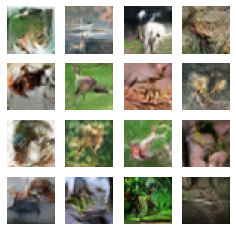

Time for training : 15390 sec


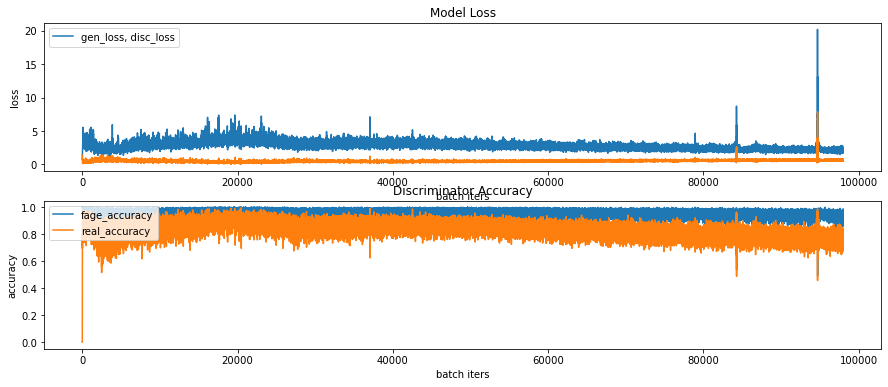

CPU times: user 4h 15min 57s, sys: 3min 42s, total: 4h 19min 40s
Wall time: 4h 16min 34s


In [44]:
%%time
train(dataset = train_dataset, epochs = epochs, save_every = save_every)

* 학습과정 시각화하기

In [45]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/cifar10_dcgan_1.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("{}/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/generated_samples/sample*.png".format(os.getenv("HOME")))
    filenames = sorted(filenames)
    last      = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else: continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/cifar10_dcgan_1.gif

-rw-r--r-- 1 aiffel-dj52 aiffel-dj52 3976479  2월 25 01:45 /home/aiffel-dj52/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/cifar10_dcgan_1.gif


In [46]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/cifar10_dcgan_2.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("{}/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/training_history/train*.png".format(os.getenv("HOME")))
    filenames = sorted(filenames)
    last      = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else: continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/cifar10_dcgan_2.gif

-rw-r--r-- 1 aiffel-dj52 aiffel-dj52 3795435  2월 25 01:45 /home/aiffel-dj52/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-4/cifar10_dcgan_2.gif


#### 9_2. 기존 모델 구조, lr = 1e-5

In [47]:
cifar10                   = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()       # y_train, y_test 데이터는 필요하지 않음.

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화 시키려고 중간값을 0으로 맞추고(그를 위해 127.5를 뺸다) 127.5로 나눈다.

buffer_size = 50000 # 전체 데이터를 섞기 위해 50000으로 지정한다.
batch_size  = 256   # 모델이 한번에 학습할 데이터의 양을 지정한다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(buffer_size).batch(batch_size) # 텐서 자료형에서 데이터셋을 만듬

def make_generator_model():
    # Start
    model = tf.keras.Sequential() # Sequential() 구조로 시작하여 구조를 쌓을 것 이다.
    
    # First : Dense layer
    model.add(tf.keras.layers.Dense(8 * 8 * 256, use_bias = False, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size = (5, 5), strides = (1, 1), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fifth : Conv2Dtrainspose layer
    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False, activation = "tanh"))
    
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# discriminator_loss
def discriminator_loss(read_output, fake_output):
    real_loss  = cross_entropy(tf.ones_like(read_output),  read_output)
    fake_loss  = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# 간단한 예시를 통해 위에 코드의 해석을 돕겠다.
# ex) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9])를 가지고 보면,

# (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
# ex) tf.Tensor([False, False, True, True])

# (2) tf.cast((1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
# ex) tf.Tensor([0.0, 0.0, 1.0, 1.0])

# (3) tf.reduce_mean((2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
# >> 0.5

noise_dim                = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

@tf.function # @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환된다.
             # 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것이다.
def train_step(images):                               # 입력데이터 : Real Image 역할을 할 images 한 세트를 입력으로 받음.
    noise = tf.random.normal([batch_size, noise_dim]) # 생성자 입력 노이즈 : generator가 Fake Image를 생성하기 위한 noise를 images 한 세트와 같은 크기인 batch_size 만큼 생성함.
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # tf.GradientTape() 오픈 : 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기.
        generated_images = generator(noise, training = True)            # generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성.
        
        # discriminator 판별
        real_output = discriminator(images,           training = True) # discriminator가 Real Image인 images를 입력받은 후 real_output 출력.
        fake_output = discriminator(generated_images, training = True) # discriminator가 Fake Image인 generated_images를 입력받은 후 fake_output 출력.
        
        # loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산.
        gen_loss  = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy 계산 : discriminator의 각각 accuracy 계산.
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴.
    return gen_loss, disc_loss, real_accuracy, fake_accuracy



In [48]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(tf.keras.layers.Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = "same", input_shape = [32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(tf.keras.layers.Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = "same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Third : Flatten layer
    model.add(tf.keras.layers.Flatten())
    
    # Fourth : Dense layer
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [49]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training = False)
    
    fig = plt.figure(figsize = (4, 4))                         # 그림 사이즈 설정하기
    for i in range(predictions.shape[0]):                      # predictions.shape[0] 시각화하기 : 여기서는 16개를 시각화 한다.
        plt.subplot(4, 4, i + 1)                               # 4행 4열로 그림을 보여준다. (row, col, index)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5)) # predictions[i]에 해당하는 그림을 그린다.
        plt.axis("off")                                        # 불필요한 축 제거
        
    # ""안의 이름으로 그림을 저장한다.
    plt.savefig("{}/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png".format(os.getenv("HOME"), epoch, it))
    
    plt.show()                              # 시각화 보여주기

In [50]:
rcParams["figure.figsize"] = 15, 6 # matlab 차트의 기본 크기를 15, 6으로 지정한다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(2, 1, 1)                                               # 위치 지정
    plt.plot(history["gen_loss"])                                      # gen_loss 선 그래프 그리기
    plt.plot(history["disc_loss"])                                     # disc_loss 선 그래프 그리기
    plt.title("Model Loss")                                            # 그림 제목 지정
    plt.ylabel("loss")                                                 # x축 이름 지정
    plt.xlabel("batch iters")                                          # y축 이름 지정
    plt.legend(["gen_loss, disc_loss"], loc = "upper left")            # 범주 만들기
    
    # summarize history for accuracy
    plt.subplot(2, 1, 2)                                               # 위치 지정
    plt.plot(history["fake_accuracy"])                                 # fake_accuracy 선 그래프 그리기
    plt.plot(history["real_accuracy"])                                 # real_accuracy 선 그래프 그리기
    plt.title("Discriminator Accuracy")                                # 그림 제목 지정
    plt.ylabel("accuracy")                                             # x축 이름 지정
    plt.xlabel("batch iters")                                          # y축 이름 지정
    plt.legend(["fage_accuracy", "real_accuracy"], loc = "upper left") # 범주 만들기
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig("{}/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/training_history/train_history_{:04d}.png".format(os.getenv("HOME"), epoch))
    plt.show()

In [51]:
checkpoint_dir    = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/training_checkpoints"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint        = tf.train.Checkpoint(generator_optimizer     = generator_optimizer,
                                        discriminator_optimizer = discriminator_optimizer,
                                        generator               = generator,
                                        discriminator           = discriminator)

In [52]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)        

In [53]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [54]:
lr = 1e-5                                              # Learning rate : 하이퍼 파라미터, 여러가지 값으로 바꿔가면서 학습을 시켜보자.

generator_optimizer     = tf.keras.optimizers.Adam(lr) # 생성자 최적화 함수
discriminator_optimizer = tf.keras.optimizers.Adam(lr) # 판별자 최적화 함수

In [55]:
def train(dataset, epochs, save_every): # epochs : 전체 학습 에포크를 결정, save_every : 모델을 저장하는 간격을 담당
    start   = time.time()
    history = {"gen_loss" : [], "disc_loss" : [], "real_accuracy" : [], "fake_accuracy" : []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait = True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print("Epoch {} | iter {}".format(epoch + 1, it + 1))
                print("Time for epoch {} : {} sec".format(epoch + 1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, it, seed)
        print("Time for training : {} sec".format(int(time.time() - start)))
        
        draw_train_history(history, epoch)
        


In [56]:
save_every = 5 
epochs     = 500

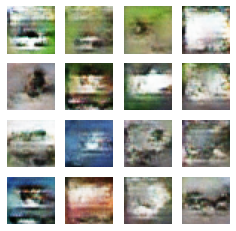

Time for training : 5637 sec


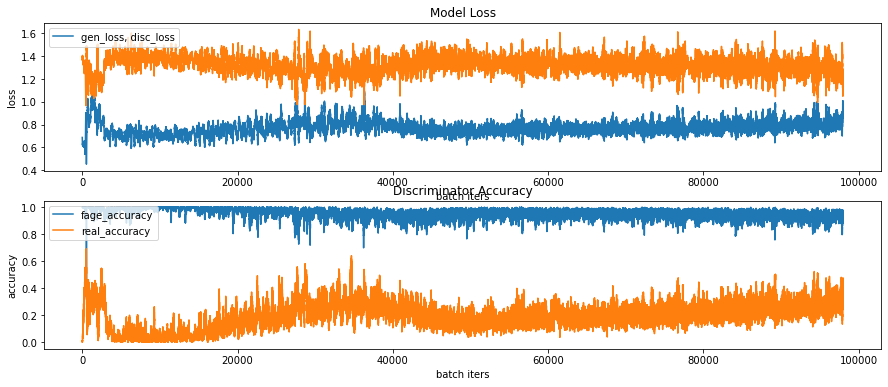

CPU times: user 1h 34min 32s, sys: 3min 13s, total: 1h 37min 46s
Wall time: 1h 34min


In [57]:
%%time
train(dataset = train_dataset, epochs = epochs, save_every = save_every)

In [58]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/cifar10_dcgan_1.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("{}/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/generated_samples/sample*.png".format(os.getenv("HOME")))
    filenames = sorted(filenames)
    last      = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else: continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/cifar10_dcgan_1.gif

-rw-r--r-- 1 aiffel-dj52 aiffel-dj52 4037264  2월 25 03:20 /home/aiffel-dj52/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/cifar10_dcgan_1.gif


In [59]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/cifar10_dcgan_2.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("{}/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/training_history/train*.png".format(os.getenv("HOME")))
    filenames = sorted(filenames)
    last      = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else: continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/cifar10_dcgan_2.gif

-rw-r--r-- 1 aiffel-dj52 aiffel-dj52 4087854  2월 25 03:20 /home/aiffel-dj52/aiffel/dcgan_newimage/cifar10_model_base_lr_1e-5/cifar10_dcgan_2.gif


#### 9_3. 새로운 모델 구조, lr = 1e-5

In [60]:
cifar10                   = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()       # y_train, y_test 데이터는 필요하지 않음.

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화 시키려고 중간값을 0으로 맞추고(그를 위해 127.5를 뺸다) 127.5로 나눈다.

buffer_size = 50000 # 전체 데이터를 섞기 위해 50000으로 지정한다.
batch_size  = 256   # 모델이 한번에 학습할 데이터의 양을 지정한다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(buffer_size).batch(batch_size) # 텐서 자료형에서 데이터셋을 만듬

def make_generator_model():
    # Start
    model = tf.keras.Sequential() # Sequential() 구조로 시작하여 구조를 쌓을 것 이다.
    
    # First : Dense layer
    model.add(tf.keras.layers.Dense(8 * 8 * 256, use_bias = False, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size = (5, 5), strides = (1, 1), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    model.add(tf.keras.layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화 시킨다
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fifth : Conv2Dtrainspose layer
    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False, activation = "tanh"))
    
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# discriminator_loss
def discriminator_loss(read_output, fake_output):
    real_loss  = cross_entropy(tf.ones_like(read_output),  read_output)
    fake_loss  = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# 간단한 예시를 통해 위에 코드의 해석을 돕겠다.
# ex) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9])를 가지고 보면,

# (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
# ex) tf.Tensor([False, False, True, True])

# (2) tf.cast((1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
# ex) tf.Tensor([0.0, 0.0, 1.0, 1.0])

# (3) tf.reduce_mean((2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
# >> 0.5

noise_dim                = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

@tf.function # @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환된다.
             # 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것이다.
def train_step(images):                               # 입력데이터 : Real Image 역할을 할 images 한 세트를 입력으로 받음.
    noise = tf.random.normal([batch_size, noise_dim]) # 생성자 입력 노이즈 : generator가 Fake Image를 생성하기 위한 noise를 images 한 세트와 같은 크기인 batch_size 만큼 생성함.
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # tf.GradientTape() 오픈 : 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기.
        generated_images = generator(noise, training = True)            # generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성.
        
        # discriminator 판별
        real_output = discriminator(images,           training = True) # discriminator가 Real Image인 images를 입력받은 후 real_output 출력.
        fake_output = discriminator(generated_images, training = True) # discriminator가 Fake Image인 generated_images를 입력받은 후 fake_output 출력.
        
        # loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산.
        gen_loss  = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy 계산 : discriminator의 각각 accuracy 계산.
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴.
    return gen_loss, disc_loss, real_accuracy, fake_accuracy



In [61]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(tf.keras.layers.Conv2D(64, kernel_size = (5, 5), strides = (1, 1), padding = "same", input_shape = [32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(tf.keras.layers.Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = "same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(256, kernel_size = (5, 5), strides = (2, 2), padding = "same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Third : Flatten layer
    model.add(tf.keras.layers.Flatten())
    
    # Fourth : Dense layer
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [62]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training = False)
    
    fig = plt.figure(figsize = (4, 4))                         # 그림 사이즈 설정하기
    for i in range(predictions.shape[0]):                      # predictions.shape[0] 시각화하기 : 여기서는 16개를 시각화 한다.
        plt.subplot(4, 4, i + 1)                               # 4행 4열로 그림을 보여준다. (row, col, index)
        plt.imshow(np.int64((predictions[i] * 127.5) + 127.5)) # predictions[i]에 해당하는 그림을 그린다.
        plt.axis("off")                                        # 불필요한 축 제거
        
    # ""안의 이름으로 그림을 저장한다.
    plt.savefig("{}/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png".format(os.getenv("HOME"), epoch, it))
    
    plt.show()                              # 시각화 보여주기

In [63]:
rcParams["figure.figsize"] = 15, 6 # matlab 차트의 기본 크기를 15, 6으로 지정한다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(2, 1, 1)                                               # 위치 지정
    plt.plot(history["gen_loss"])                                      # gen_loss 선 그래프 그리기
    plt.plot(history["disc_loss"])                                     # disc_loss 선 그래프 그리기
    plt.title("Model Loss")                                            # 그림 제목 지정
    plt.ylabel("loss")                                                 # x축 이름 지정
    plt.xlabel("batch iters")                                          # y축 이름 지정
    plt.legend(["gen_loss, disc_loss"], loc = "upper left")            # 범주 만들기
    
    # summarize history for accuracy
    plt.subplot(2, 1, 2)                                               # 위치 지정
    plt.plot(history["fake_accuracy"])                                 # fake_accuracy 선 그래프 그리기
    plt.plot(history["real_accuracy"])                                 # real_accuracy 선 그래프 그리기
    plt.title("Discriminator Accuracy")                                # 그림 제목 지정
    plt.ylabel("accuracy")                                             # x축 이름 지정
    plt.xlabel("batch iters")                                          # y축 이름 지정
    plt.legend(["fage_accuracy", "real_accuracy"], loc = "upper left") # 범주 만들기
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig("{}/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/training_history/train_history_{:04d}.png".format(os.getenv("HOME"), epoch))
    plt.show()

In [64]:
checkpoint_dir    = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/training_checkpoints"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint        = tf.train.Checkpoint(generator_optimizer     = generator_optimizer,
                                        discriminator_optimizer = discriminator_optimizer,
                                        generator               = generator,
                                        discriminator           = discriminator)

In [65]:
generator = make_generator_model()

generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 128)        

In [66]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)        

In [67]:
lr = 1e-5                                              # Learning rate : 하이퍼 파라미터, 여러가지 값으로 바꿔가면서 학습을 시켜보자.

generator_optimizer     = tf.keras.optimizers.Adam(lr) # 생성자 최적화 함수
discriminator_optimizer = tf.keras.optimizers.Adam(lr) # 판별자 최적화 함수

In [68]:
def train(dataset, epochs, save_every): # epochs : 전체 학습 에포크를 결정, save_every : 모델을 저장하는 간격을 담당
    start   = time.time()
    history = {"gen_loss" : [], "disc_loss" : [], "real_accuracy" : [], "fake_accuracy" : []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait = True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print("Epoch {} | iter {}".format(epoch + 1, it + 1))
                print("Time for epoch {} : {} sec".format(epoch + 1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, it, seed)
        print("Time for training : {} sec".format(int(time.time() - start)))
        
        draw_train_history(history, epoch)
        


In [69]:
save_every = 5 
epochs     = 500

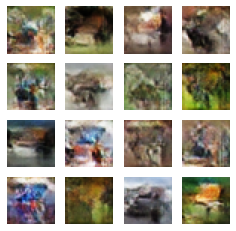

Time for training : 15319 sec


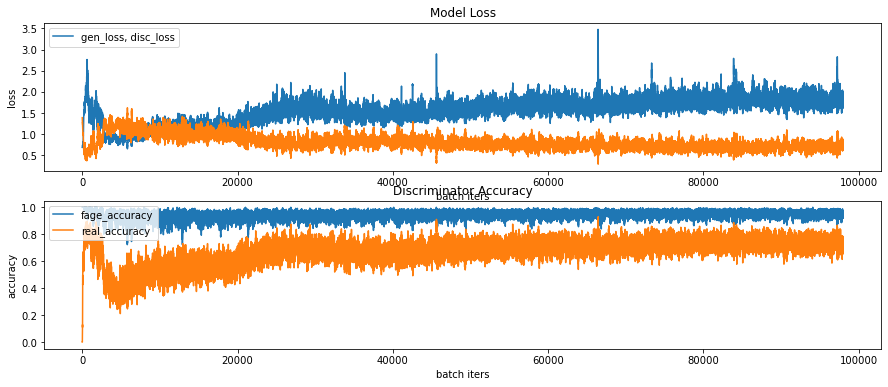

CPU times: user 4h 15min 29s, sys: 3min 18s, total: 4h 18min 48s
Wall time: 4h 15min 23s


In [70]:
%%time
train(dataset = train_dataset, epochs = epochs, save_every = save_every)

In [71]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/cifar10_dcgan_1.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("{}/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/generated_samples/sample*.png".format(os.getenv("HOME")))
    filenames = sorted(filenames)
    last      = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else: continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/cifar10_dcgan_1.gif

-rw-r--r-- 1 aiffel-dj52 aiffel-dj52 3982875  2월 25 07:35 /home/aiffel-dj52/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/cifar10_dcgan_1.gif


In [72]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/cifar10_dcgan_2.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("{}/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/training_history/train*.png".format(os.getenv("HOME")))
    filenames = sorted(filenames)
    last      = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else: continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/cifar10_dcgan_2.gif

-rw-r--r-- 1 aiffel-dj52 aiffel-dj52 3908858  2월 25 07:35 /home/aiffel-dj52/aiffel/dcgan_newimage/cifar10_model_new_lr_1e-5/cifar10_dcgan_2.gif


모델들의 시각화 사진인 gif파일을 github 올리니 안 보여서 블로그에 올렸다.
https://ehdgns.tistory.com/69

## 회고록

In [74]:
# 처음에 진행할 때 시각화를 어떻게 해야하는지에 대해서 너무 어려워서 노드대로 하고, 
# 모델에 레이어를 1계층 더 쌓아서 새로운 모델 1개와 lr을 1e-4에서 1e-5로 바꾸어서 총 4개의 모델을 만들고,
# epochs는 1000으로 해서 한 모델당 4 ~ 6시간을 투자해서 학습을 시켜보려했으나 코딩을 잘못해서 1개의 모델만 온전히 1000번 학습했다.

# 1000번의 학습이 진행된 모델의 기록들을 보니까
# 시각화가 너무 초록초록하게 나와서 시각화에 신경을 써야 한다는 것을 깨닫고, 어떻게 하면 시각화를 0 ~ 255로 돌려서 컬러로 할 수 있을지 많이 고민했다.
# 구글링을 하니 int8을 써보라 하는데 이상하게 시각화가 되어서 내가 정규화 시킨 과정을 다시 역산을 해서 돌리면 어떨까...하고 생각했다.
# 노이즈 발생으로 시각화를 하고 컬러바를 보니 먼가 잘 시각화 된거 같아서 다시 1000번을 돌려봤다.
# 근데 500번이 넘어가니 먼가 그림이 이상해지고 뿌옇게 되는 것 같아서 다시 전부 멈추고 epochs를 500으로 줘서 다시 돌려보았다.
# 500번도 너무 시간이 오래 걸려서 밤새 틀어놓고 퇴근하고 다음날 출근하여 결과를 확인했다.

# 기존 모델이 새로운 모델보다 성능이 좋았다고 판단되고,
# lr은 1e-4가 1e-5보다 더 좋았다고 판단되었다.